# Followers: What do they tweet about?

In [1]:
import pandas as pd
import numpy as np
import config
import sys
import re
from ast import literal_eval
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import wordcloud
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

pd.set_option('display.max_colwidth', 100)

In [2]:
target = config.target_user
target_month = config.target_month

In [3]:
source_dir = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target)

tokenized_and_preprocessed_file = '/'.join([source_dir, target_month  + '_tokenized_and_preprocessed.csv'])
english_file = '/'.join([source_dir, target_month  + '_english.csv'])
french_file = '/'.join([source_dir, target_month  + '_french.csv'])
german_file = '/'.join([source_dir, target_month  + '_german.csv'])

## Tweets in English

In [4]:
tweets_english = pd.read_csv(english_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

def remove_hash(wordlist):
    return(list(map(lambda x: re.sub(r'^#','',x), wordlist)))

def remove_at(wordlist):
    return(list(map(lambda x: re.sub(r'^@','',x), wordlist)))
    
tweets_english['text_wo_#'] = tweets_english['text_processed'].apply(lambda x: remove_hash(x))
tweets_english['text_wo_#@'] = tweets_english['text_wo_#'].apply(lambda x: remove_at(x))

X_train_en = tweets_english['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("english"))
#relevant_words = set(['not', 'nor', 'no', 'wasn', 'ain', 'aren', 'very', 'only', 'but', 'don', 'isn', 'weren'])
relevant_words = set()
additional_stopwords = set(['us'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [5]:
X_train_en[-10:-1]

5495    Just released Windows developer evaluation virtual machines October 2016 build We re releasing t...
5496    NikoNeugebauer Woohoo ssis deep dive was so fast that it has finished in just 40 minutes instead...
5497    rustyrazorblade About Deletes and Tombstones in Cassandra by arodream should be mandatory readin...
5498                                                       RethinkYourData TOMBSTONES FOR THE TOMBSTONE GOD
5499                                    lukaseder The truth about working from home https://t.co/GQVKAaDCIQ
5500    brendangregg Intel are doing great work tracking language performance Java Node.js/python/php/ h...
5501    RoelH orclapex The APEXpress Weekly is out https://t.co/cNcNf9ZAce Stories kp4912t vincentmornea...
5502    shakeeb More orclapex stickers for some very talented Japanese developers WereBigInJapan oradev ...
5503    rustyrazorblade About Deletes and Tombstones in Cassandra by arodream should be mandatory readin...
Name: text_wo_#@, dtype: obj

In [6]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)
feature_names = vectorizer.get_feature_names()

In [7]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

In [8]:
def generate_word_cloud(model, topic_number, max_words, width, height):
    topic = model.components_[topic_number]
    frequencies = [(feature_names[i], topic[i]) for i in topic.argsort()]
    top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
    cloud = wordcloud.WordCloud(width=width, height=height, max_words=max_words, random_state=0).generate_from_frequencies(frequencies)
    return cloud
  
def show_word_clouds(model, subplots, num_words):    
    for i in range(model.n_topics):
        wordcloud = generate_word_cloud(model = model, topic_number = i, max_words = num_words,width = 800, height = 600)
        subplots[i].imshow(wordcloud)
        subplots[i].axis('off')

def print_top_words(model, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))
        print()
    


## Most dominating topics - overall

Topic #0:
593.8: oracle
473.5: lukaseder
388.5: new
313.3: data
270.7: cloud
244.6: iamcp
213.0: industry
211.8: sfonplsql
204.6: description
204.3: talend



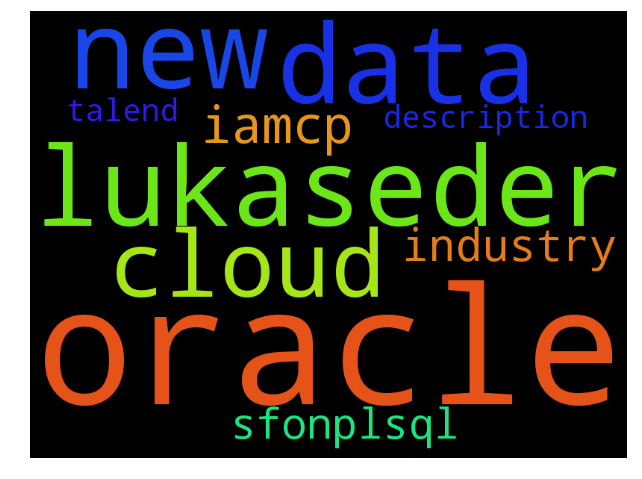

In [9]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)


## Most dominating topics - 2 clusters

Topic #0:
473.0: lukaseder
212.5: industry
204.1: description
199.7: https://t.co/k9lyskoe0g
199.7: accurate
175.2: great
169.0: oracle
133.1: cce16
131.0: one
128.1: it's
117.1: microsoft
113.9: like
112.0: new
109.5: :)
108.0: really
107.5: 10
105.9: cloud
102.8: time
101.6: don't
101.2: talend

Topic #1:
424.8: oracle
276.5: new
243.4: iamcp
241.5: data
199.2: bigdata
185.7: 2016
176.7: sfonplsql
164.8: cloud
131.3: orclapex
109.3: week
105.8: analytics
105.7: hadoop
103.1: talend
100.3: spark
98.2: sql
93.1: thanks
92.5: october
92.0: know
91.7: available
88.5: database



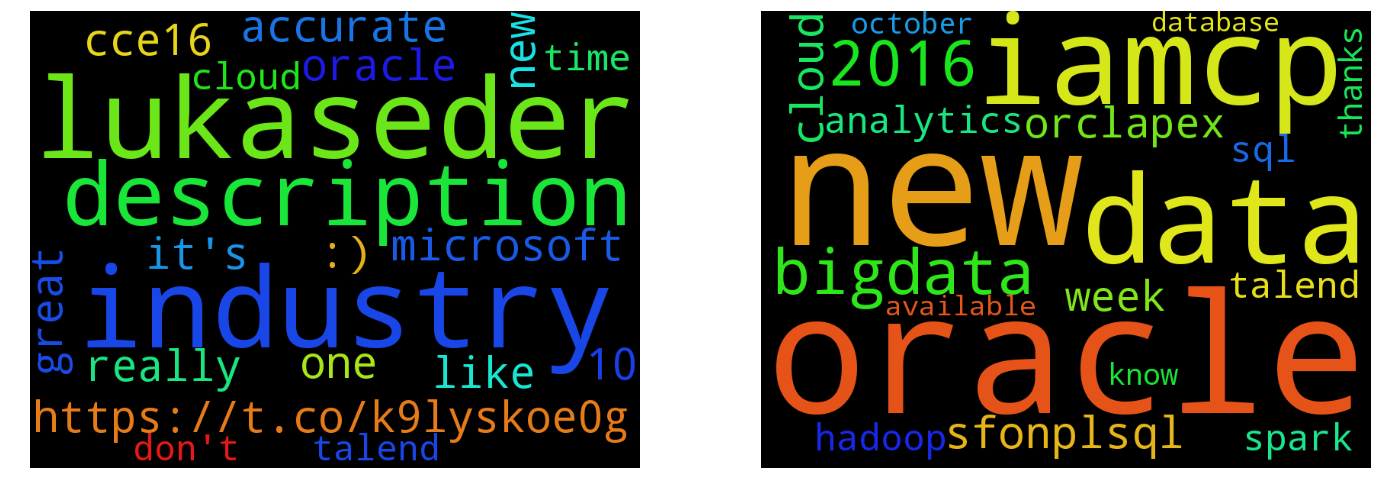

In [10]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters

Topic #0:
472.8: lukaseder
212.4: industry
203.9: description
199.6: https://t.co/k9lyskoe0g
199.6: accurate
120.6: today
118.4: get
109.2: :)
107.8: really
94.1: talend
92.2: one
85.1: microsoft
82.6: it's
81.8: new
81.5: still
80.2: see
74.0: 10
68.9: partners
68.0: would
66.5: make

Topic #1:
359.0: oracle
252.3: new
238.7: data
199.0: bigdata
165.3: iamcp
157.8: 2016
121.6: cloud
109.8: talend
105.7: analytics
105.5: hadoop
100.2: spark
95.3: thanks
92.4: october
88.4: available
81.8: blog
79.3: windows
75.7: partner
75.6: database
75.0: business
74.9: latest

Topic #2:
190.9: oracle
150.7: use
143.1: know
139.9: sfonplsql
131.2: great
106.9: cloud
102.2: sql
100.1: time
87.6: thanks
83.4: pay
74.9: orclapex
74.3: data
70.8: oracledatabase
69.1: 2
67.3: cce16
66.7: people
65.7: next
64.1: week
64.0: first
63.4: franckpachot



(0.0, 1.0, 0.0, 1.0)

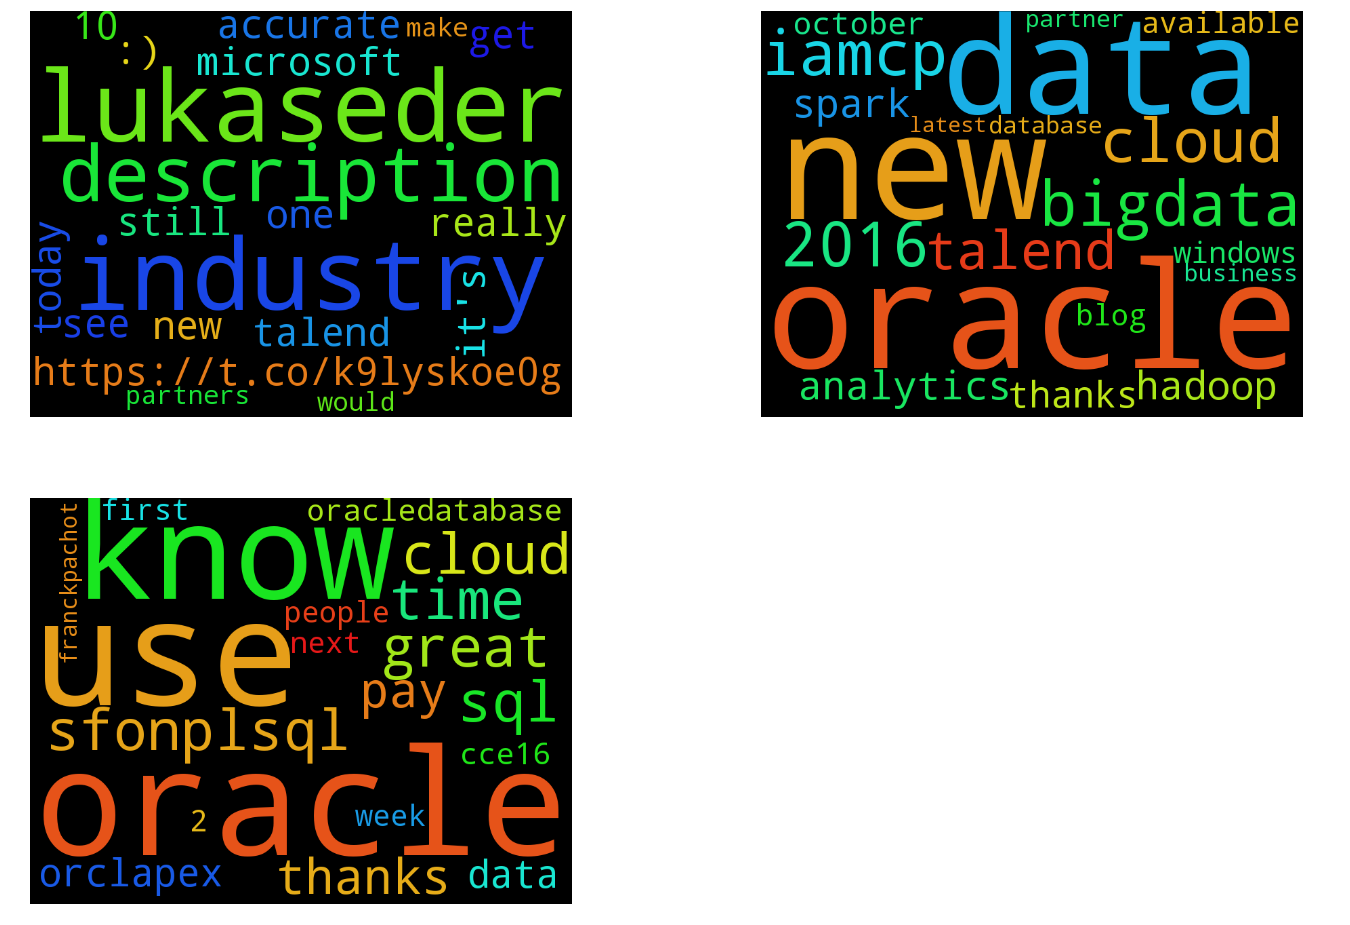

In [11]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters

Topic #0:
472.7: lukaseder
212.3: industry
203.9: description
199.5: https://t.co/k9lyskoe0g
199.5: accurate
109.4: :)
107.7: really
106.3: it's
95.5: one
83.1: see
82.8: great
81.4: still
76.7: oracle
74.7: don't
69.9: live
68.0: would
66.5: make
66.2: sql
62.3: yes
60.9: like

Topic #1:
312.1: data
257.8: new
199.0: bigdata
162.3: oracle
120.3: talend
105.7: analytics
105.5: hadoop
100.6: thanks
100.1: spark
86.3: 1
77.1: business
74.1: want
73.2: big
73.1: latest
66.1: work
64.6: change
61.2: sfonplsql
59.2: w
53.4: 5
52.8: blog

Topic #2:
275.9: oracle
150.1: sfonplsql
143.2: know
136.9: database
130.8: cloud
111.3: sql
107.9: 10
104.6: new
103.0: time
83.3: pay
82.2: use
73.7: great
71.7: things
71.0: 2
70.8: oracledatabase
65.8: next
64.4: thanks
63.4: franckpachot
62.6: open
59.5: orclapex

Topic #3:
157.6: iamcp
142.3: 2016
113.2: get
87.9: cloud
86.0: iamcpus
83.0: iot
80.2: october
78.8: oracle
76.8: day
75.7: partner
73.0: azure
70.6: available
67.4: people
61.8: java
60.8: 

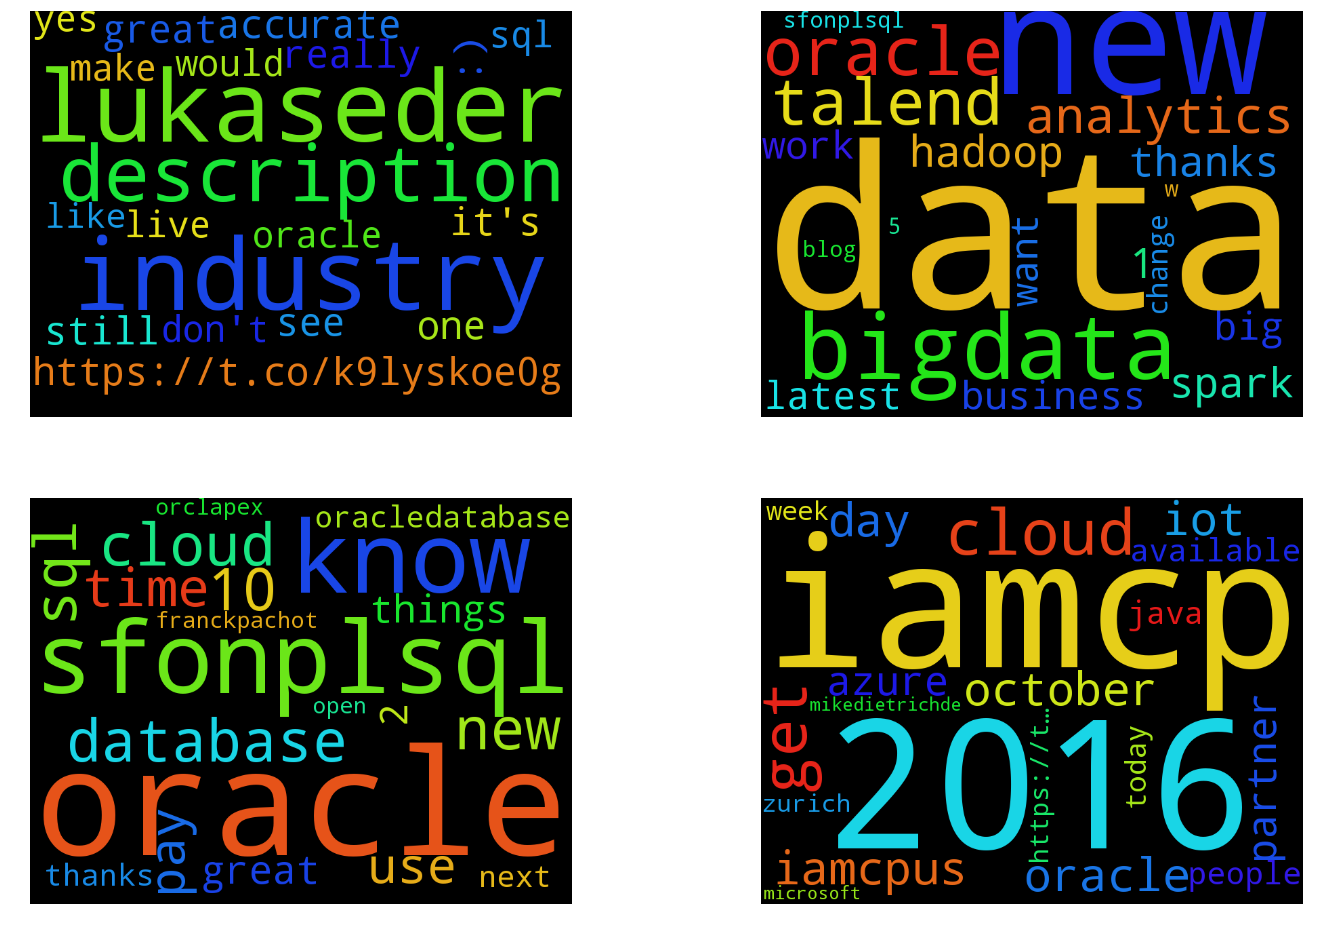

In [12]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

In [13]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)
co_occurrences.shape

(12630, 12630)

In [14]:
vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.head()

,0,1,2,3,4,5,6,7,8,9,...,12620,12621,12622,12623,12624,12625,12626,12627,12628,12629
word,,,,,,,,,,,,,,,,,,,,,
#ff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,2,0,0
%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
);,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
co_occurrences.columns = vocab
co_occurrences.head()

,#ff,$,%,):,);,)=,-2.0-,-3109-1,.,..,...,😮,😳,🙂,🙃,🙄,🙏,🚀,🤓,🤘,🦁
word,,,,,,,,,,,,,,,,,,,,,
#ff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,2,0,0
%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
);,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Co-occurrences for: oracle
cloud             159
database          123
new                86
data               65
2016               60
service            48
october            44
available          44
12c                37
oraclepartners     33
patch              31
12.2               31
Name: oracle, dtype: int64




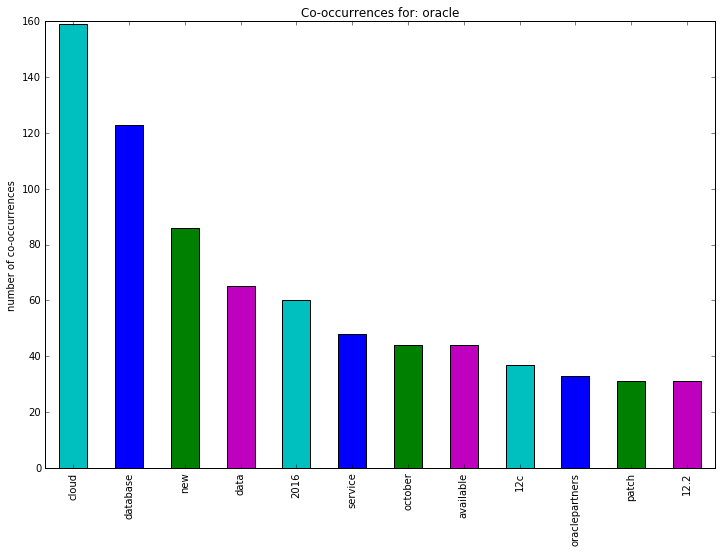

Co-occurrences for: microsoft
partners        38
iamcp           38
city            30
10              26
windows         24
event           23
safer           22
msftcitynext    21
cloud           16
launch          16
solutions       16
smart           15
Name: microsoft, dtype: int64




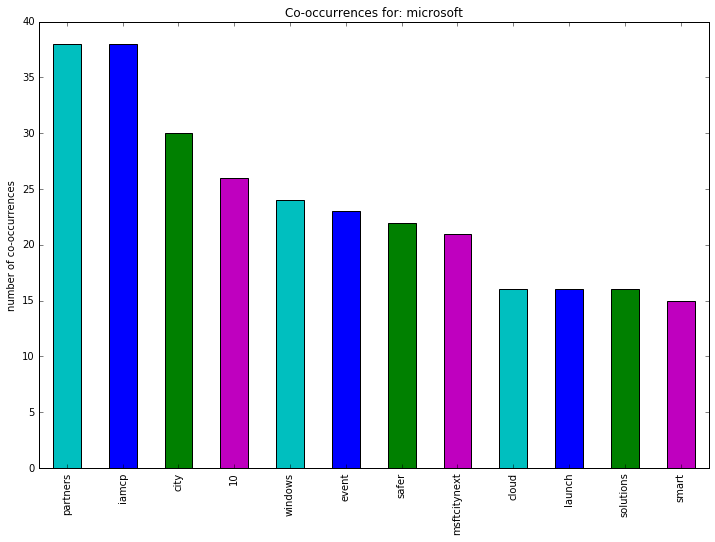

Co-occurrences for: talend
bigdata            93
10                 62
dataintegration    50
hadoop             40
looks              33
co-founder         33
back               33
bdiard             33
data               30
etl                25
years              19
easy               19
Name: talend, dtype: int64




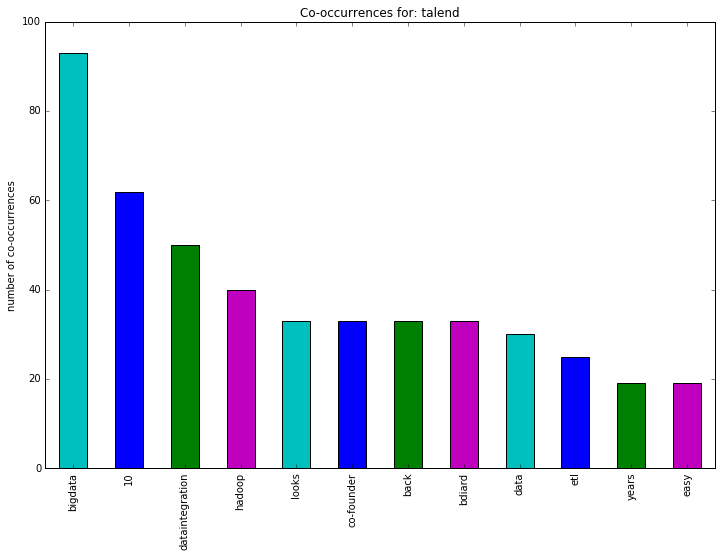

Co-occurrences for: bigdata
talend             93
hadoop             63
analytics          40
data               37
machinelearning    27
datascience        27
new                18
powered            17
berlin             17
strategy           16
apachespark        15
ai                 15
Name: bigdata, dtype: int64




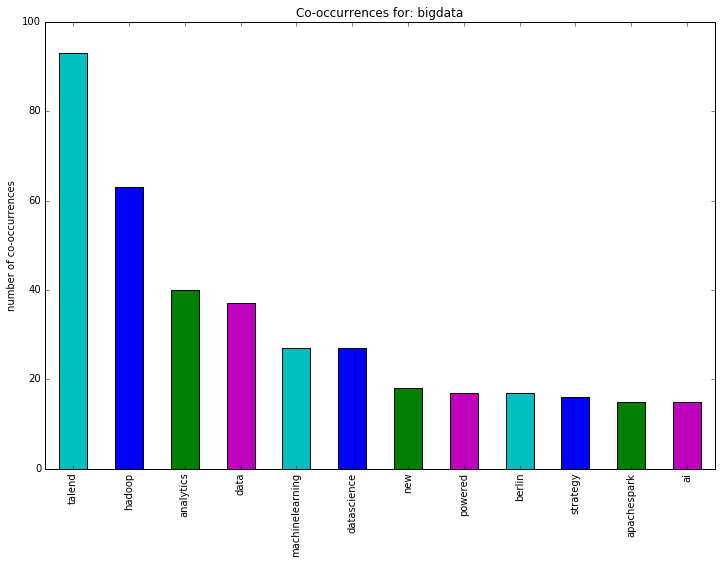

Co-occurrences for: cloud
oracle            159
oraclepartners     50
service            45
new                33
data               30
move               30
services           24
free               23
help               21
profit             19
learning           19
train              18
Name: cloud, dtype: int64




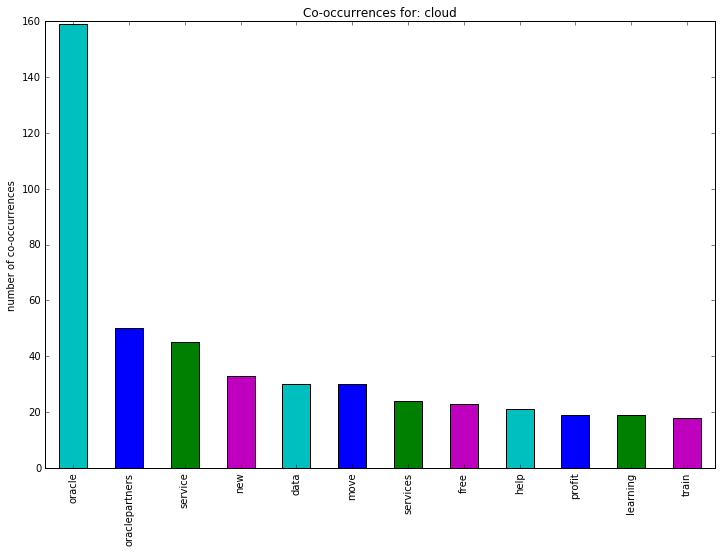

In [16]:
def get_co_occurrences(df, word, n):
    coocs = df.loc[word]
    sorted = coocs.sort_values(ascending = False)
    return sorted[:n]

def plot_co_occurrences(word, coocs):
    plt.figure(figsize = (12, 8))
    plt.ylabel('number of co-occurrences')
    plt.title('Co-occurrences for: {}'.format(word))
    coocs.plot(kind='bar', color = colors)
    plt.show()
    
words = ['oracle', 'microsoft', 'talend', 'bigdata', 'cloud']    
n = 12
colors = 'cbgm'

for w in words: 
    coocs = get_co_occurrences(co_occurrences, w, n)
    print('Co-occurrences for: {}\n{}\n\n'.format(w, coocs))
    plot_co_occurrences(w, coocs)


# Tweets in German

In [17]:
tweets_german = pd.read_csv(german_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
    
tweets_german['text_wo_#'] = tweets_german['text_processed'].apply(lambda x: remove_hash(x))
tweets_german['text_wo_#@'] = tweets_german['text_wo_#'].apply(lambda x: remove_at(x))

X_train_de = tweets_german['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("german"))
stopwords_nltk
#relevant_words = set(['aber', 'nicht', 'nichts', 'ohne', 'nur', 'sehr', 'sollte', 'viel'])
relevant_words = set()
additional_stopwords = set([''])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [18]:
X_train_de[-10:]

2355       berndmuller Zum Trost Die guten Bilder werden auf der Web-Site vom Java Forum Nord zu sehen sein
2356    INFOGRAZ Endlich 4 Alben von Most Jazz https://t.co/1wq6MDm8k5 und lange Nacht der Museen https:...
2357                                                      Bauernopfer Risikomanager https://t.co/mWwSchu99m
2358    BASTAcon Nur noch knapp 2 Wochen bis zu 970 € sparen und zudem einen Workshop Tag ein Tablet for...
2359                          Was Mitarbeiter tatsächlich wollen https://t.co/Vd4dUtqzLN EmployeeEngagement
2360    Liebe Timeline ich freue mich wie Bolle wenn xpiratar was wird aber ich kann kein Isländisch bit...
2361    JustynaGrund Clinique Prep Pep Go Event Oder einfach pep-start Das sind die neuen Produkte https...
2362    DOAGeV Neuer DOAGTermin 18.11 2016 Regionaltreffen Rhein-Main APEX Meetup APEX Meetup https://t....
2363                                                              INFOGRAZ Danke fuers Follow Es freut mich
2364    SBB der neue Fahrpla

In [19]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_de)
feature_names = vectorizer.get_feature_names()

In [20]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

## Most dominating topics - overall - German

Topic #0:
151.2: msenterprisede
103.1: javaforumnord
103.0: mscloudde
102.2: deutsche
99.4: https://t…
94.2: danke
93.5: sicherheit
90.7: msft
89.5: setzt
86.9: germany



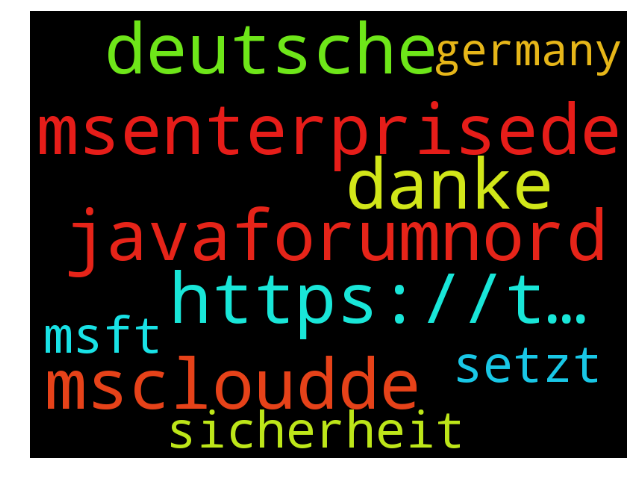

In [21]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - German

Topic #0:
145.6: msenterprisede
102.5: mscloudde
101.7: deutsche
98.8: https://t…
93.0: sicherheit
90.2: msft
89.0: setzt
86.4: germany
86.4: sicherheitszertifikat
86.4: made
86.4: d-trust
72.4: jfn16
70.7: cloud
57.4: neue
54.6: oracle
52.8: java
52.4: “
50.3: 2016
49.9: mehr
49.2: https

Topic #1:
93.0: danke
54.8: javaforumnord
46.6: wer
45.8: 4
44.4: meetup
43.0: digitalisierung
38.6: ja
37.6: schon
36.9: kommt
36.2: nacht
36.2: geht
35.9: mal
34.8: orclapex
33.3: dass
32.3: heute
32.0: 2
31.5: dank
31.2: newsletter
30.6: microsoftde
30.1: viele



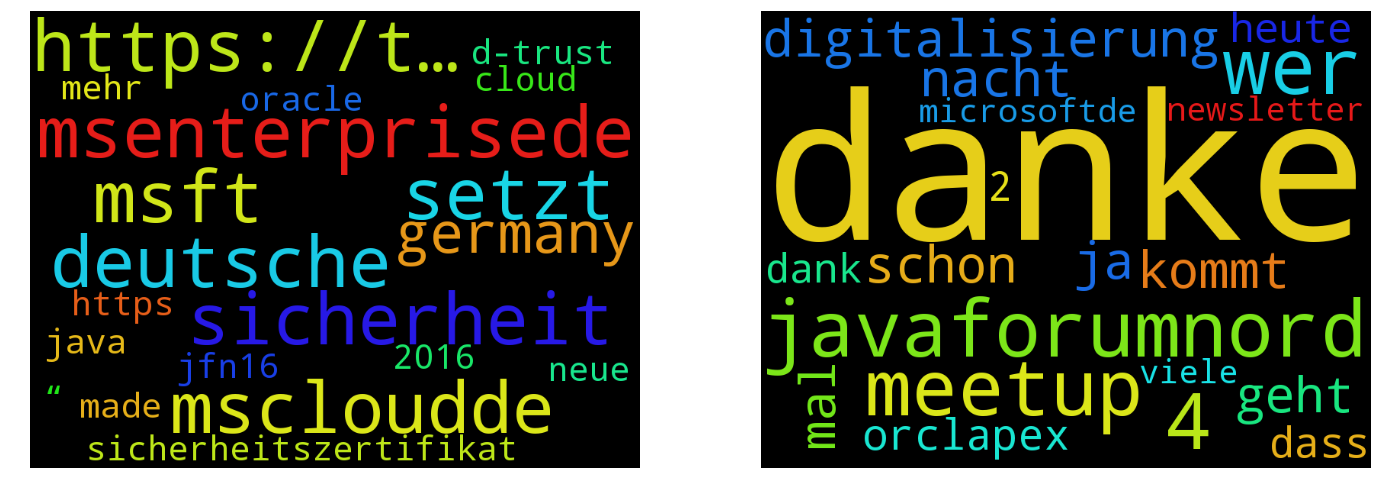

In [22]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - German

Topic #0:
150.3: msenterprisede
102.3: mscloudde
101.5: deutsche
98.7: https://t…
92.8: sicherheit
90.0: msft
88.8: setzt
86.2: germany
86.2: d-trust
86.2: sicherheitszertifikat
86.2: made
56.0: cloud
44.9: 2016
43.3: oracle
39.1: “
34.8: itawards
34.0: neue
33.9: „
32.0: jfn16
29.7: doagev

Topic #1:
61.8: danke
44.2: meetup
43.0: digitalisierung
36.1: nacht
35.9: bigdata
34.6: orclapex
33.6: mal
32.8: dass
31.5: dank
31.2: newsletter
30.5: ja
30.3: neuer
29.0: :-)
28.3: apex
27.6: lange
26.5: doag2016
26.3: bigdata_insider
25.7: bitte
25.1: neuen
24.6: geht

Topic #2:
101.8: javaforumnord
58.9: ab
45.7: wer
44.5: mehr
42.4: 2
40.9: jfn16
31.9: danke
31.6: verfügbar
31.5: nord
31.5: forum
31.4: heute
30.6: microsoftde
30.1: https
30.1: microsoft
28.4: java
28.1: hamed_samad
26.8: bilder
26.1: https://t.c…
25.9: neues
25.4: event



(0.0, 1.0, 0.0, 1.0)

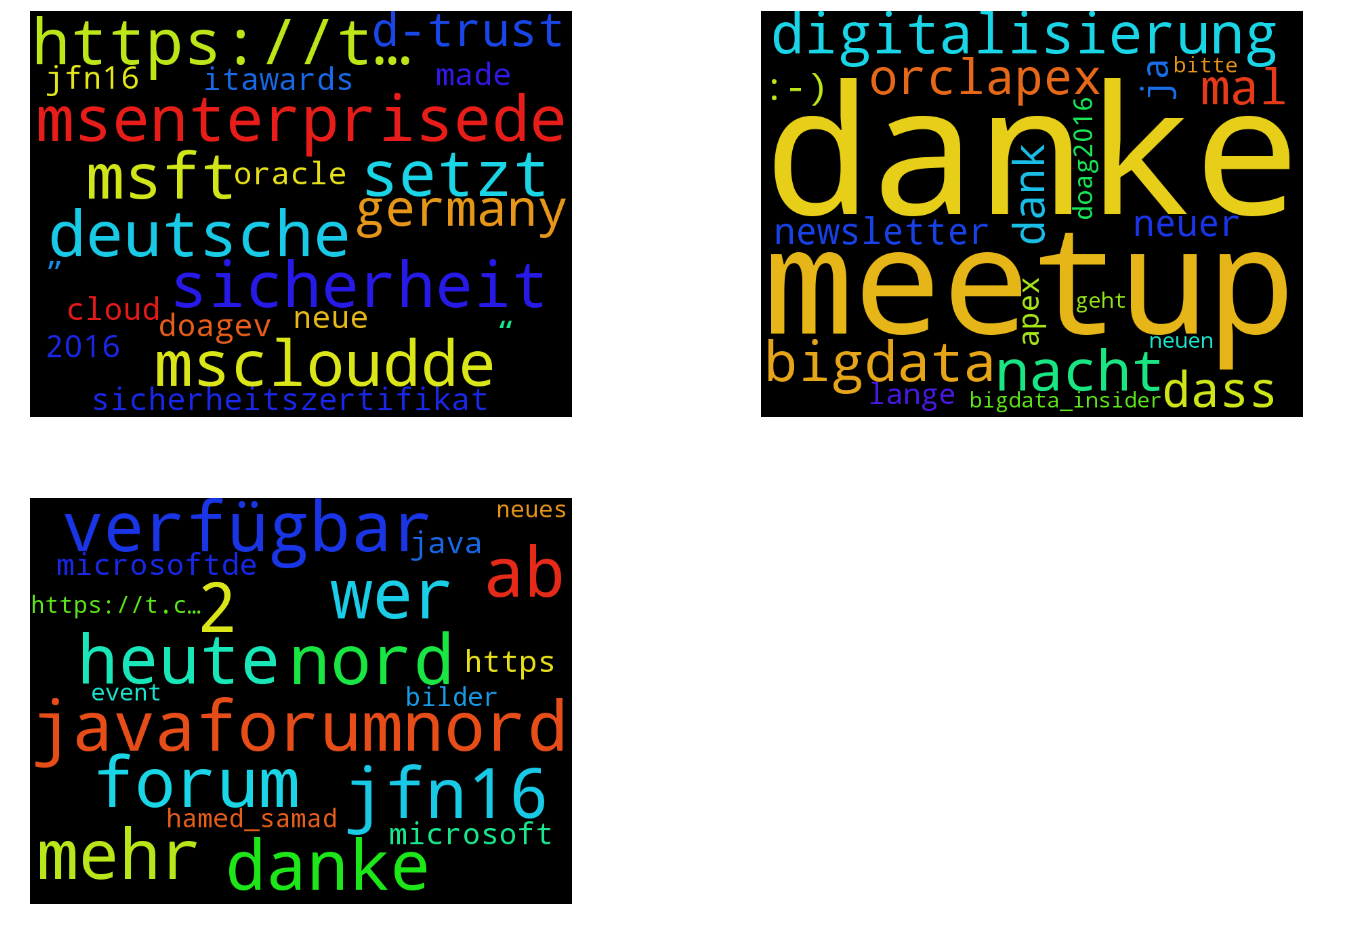

In [23]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters - German

Topic #0:
57.0: cloud
54.7: neue
52.8: heute
45.6: javaforumnord
45.5: 2
44.1: jfn16
42.9: gibt
40.9: sap
39.5: nächste
35.8: java
35.7: 1
32.0: doagev
31.8: 2016
29.8: oracle
29.1: s
27.2: oc_wire
27.1: 4
26.2: dabei
26.1: berlin
25.8: raum

Topic #1:
42.9: digitalisierung
38.7: geht
36.2: bigdata
32.6: doag2016
31.1: newsletter
28.2: apex
27.3: meetup
26.5: ;-)
26.2: oracle
25.1: neuen
24.4: november
24.1: schweizer
22.0: gute
21.7: doagev
21.0: oraesque
21.0: neuer
20.8: 2016
20.8: appsassociatesd
20.4: bigdata_insider
20.1: immer

Topic #2:
53.8: ab
48.4: itawards
46.8: javaforumnord
43.2: https
42.1: danke
41.7: wer
37.3: schon
30.5: microsoftde
28.6: jfn16
28.3: verfügbar
28.2: neues
27.9: https://t.c…
26.8: jahr
25.4: microsoft
25.1: cloudinsiderde
24.9: sapdach
23.8: deutscher
23.2: socialmedia
22.7: 2016
22.4: kommt

Topic #3:
150.4: msenterprisede
102.2: mscloudde
101.4: deutsche
98.6: https://t…
92.7: sicherheit
89.9: msft
88.7: setzt
86.1: made
86.1: sicherheitszertifikat
8

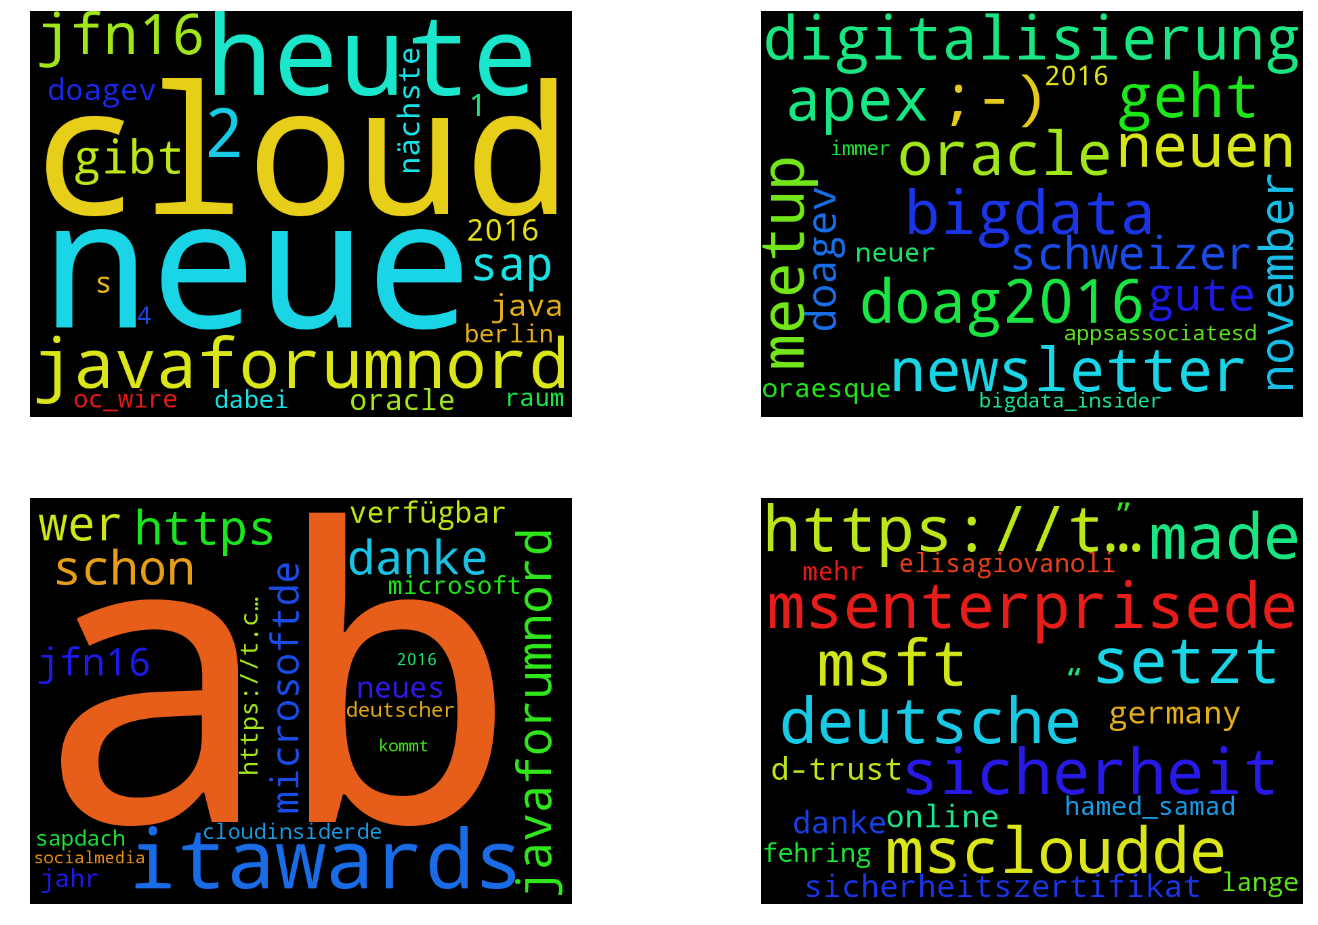

In [24]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

Co-occurrences for: java
nord             36
forum            36
jfn16            23
javaforumnord    18
neues            12
event            11
social           11
teilnehmer       11
tracks           11
iot-workshop     11
2                11
400              11
Name: java, dtype: int64




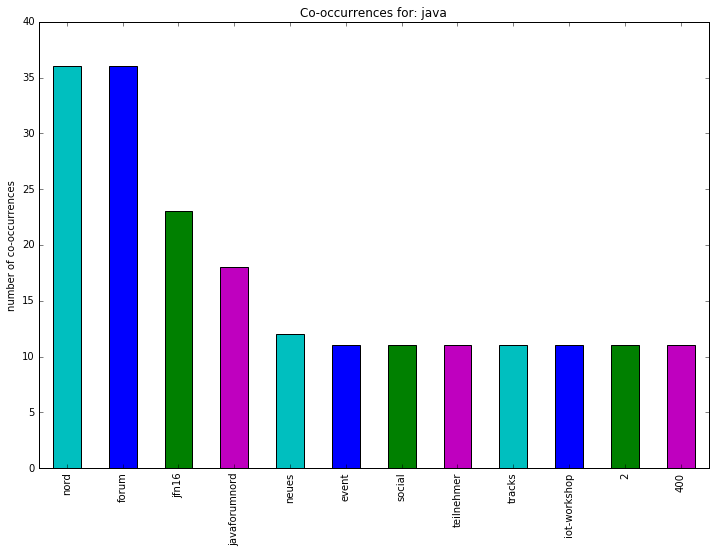

Co-occurrences for: sap
erpsourcing       20
frankgeisler1     18
sapdach           17
interessante      13
regensdorf         9
spannende          8
2                  7
präsentation       7
socsellch          7
hervorragenden     7
java               6
jochenvatter       6
Name: sap, dtype: int64




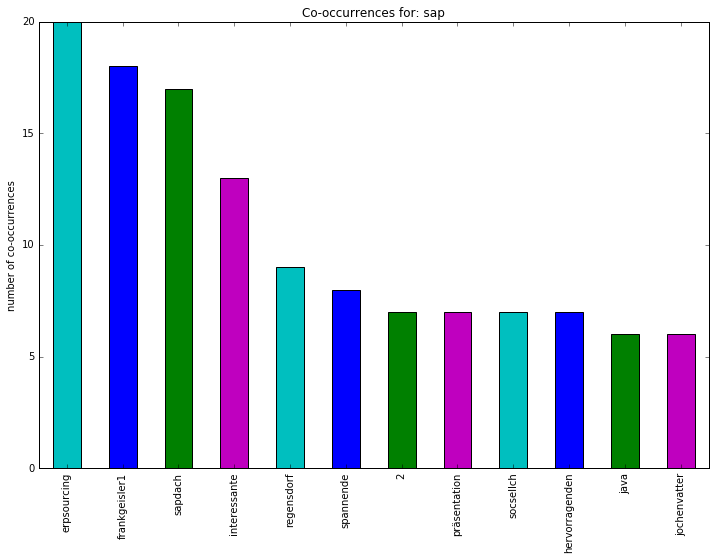

In [25]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_de)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)

vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.columns = vocab

words = ['java', 'sap']    
n = 12
colors = 'cbgm'

for w in words: 
    coocs = get_co_occurrences(co_occurrences, w, n)
    print('Co-occurrences for: {}\n{}\n\n'.format(w, coocs))
    plot_co_occurrences(w, coocs)

# Tweets in French

In [26]:
tweets_french = pd.read_csv(french_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
    
tweets_french['text_wo_#'] = tweets_french['text_processed'].apply(lambda x: remove_hash(x))
tweets_french['text_wo_#@'] = tweets_french['text_wo_#'].apply(lambda x: remove_at(x))

X_train_fr = tweets_french['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("french"))
stopwords_nltk
relevant_words = set([])

additional_stopwords = set(['les'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [27]:
X_train_fr[-10:]

80                                vipmis Attending Odd in Vancouver orclapex vodd https://t.co/0k3YupjCra
81    La faille DirtyCOW impacte aussi Android et permet de rooter votre smartphone Un patch est à ven...
82                       Mise à jour pour iMovie en version 10.1 3 ValerieAMaitre https://t.co/FjjGn77az7
83                                                                               yoannpele nickel merci 😉
84                                                                                         mp911de Touché
85                                                                                     supaheld meeh Bier
86    Nous développons notre implantation en Suisse romande et recherchons un e Employé e de support d...
87    FrankGeisler1 SAP SAPdach sap_berater NikolausKoepfer ChNaegele SvenTschenett Eshaghi_A viktorgi...
88    net4allch IoT et mots de passe par défaut Attention vos objets connectés pourraient bien servir ...
89                                            

In [28]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_fr)
feature_names = vectorizer.get_feature_names()

In [29]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

## Most dominating topics - overall - French

Topic #0:
11.4: oracle_france
9.8: welovestartups
9.1: oracle
8.2: talendfr
8.2: rdv
8.2: oracledigital
7.5: jpmichenaud
7.4: e
7.4: day
7.4: suisse



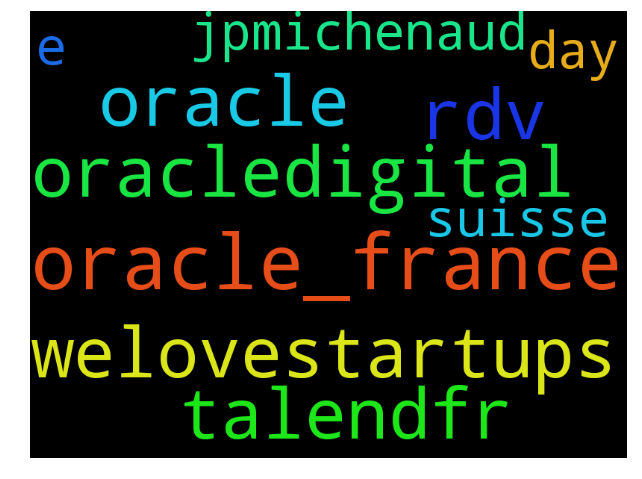

In [30]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - French

Topic #0:
7.0: e
5.4: oracle
4.6: oracledigital
3.9: 2016
3.9: talendfr
3.8: bigdata
3.8: rdv
3.8: suisse
3.7: a
3.0: recommendations
3.0: support
3.0: romande
3.0: ddos
3.0: pratiques
3.0: employé
3.0: blog
3.0: applications
3.0: strauch5
2.9: recherchons
2.9: développons

Topic #1:
10.8: oracle_france
9.3: welovestartups
6.4: day
6.2: jpmichenaud
4.6: rdv
4.6: talend
4.6: talendfr
4.5: sparksummit
4.3: direct
3.9: nov
3.9: oracledigital
3.8: oracle
3.8: 8
3.8: ceo
3.8: digital
3.8: suisse
3.8: start-ups
3.8: https://t.co/yyohfsispq
3.8: bigdata
3.7: anime



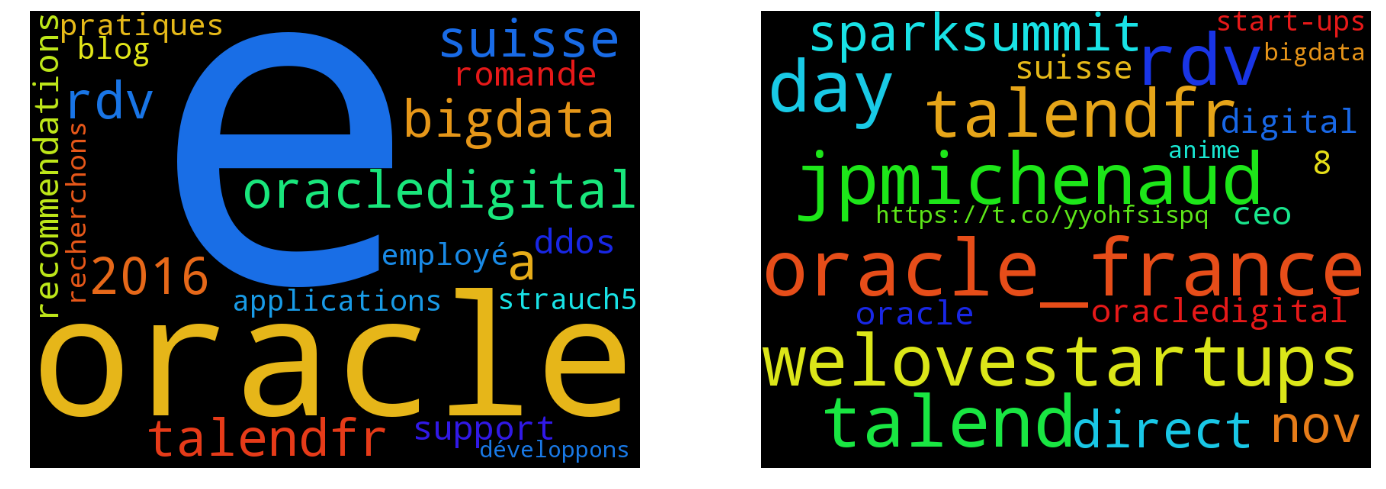

In [31]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - French

Topic #0:
6.8: e
5.9: oracledigital
5.1: rdv
4.5: talendfr
4.5: bigdata
4.4: oracle
4.3: 8
4.3: nov
3.7: 2016
3.7: a
2.9: recommendations
2.9: support
2.9: pratiques
2.9: romande
2.9: blog
2.9: talend
2.9: employé
2.9: applications
2.9: suisse
2.8: recherchons

Topic #1:
9.9: oracle_france
9.1: welovestartups
6.0: day
5.3: jpmichenaud
3.7: talend
3.7: suisse
3.7: ceo
3.7: talendfr
3.7: sparksummit
3.7: start-ups
3.6: https://t.co/yyohfsispq
3.6: anime
3.6: table-ronde
3.6: damiengromier
3.6: frdigitale
2.9: digital
2.9: offer
2.9: genève
2.9: reward
2.9: competitive

Topic #2:
3.0: direct
2.9: oracle
2.9: strauch5
2.4: https://t.co/4jbuphyxsi
2.2: rdv
2.1: gardez
2.1: 21
2.1: oracledigital
2.1: exécution
2.1: :-)
2.1: décembre
2.1: |
2.1: https://t.co/9kwgglqxte
2.1: formation
2.1: https://t.co/dbxy4iat48
2.1: là
2.1: pc
2.1: garantie
2.1: iot
2.1: introduction



(0.0, 1.0, 0.0, 1.0)

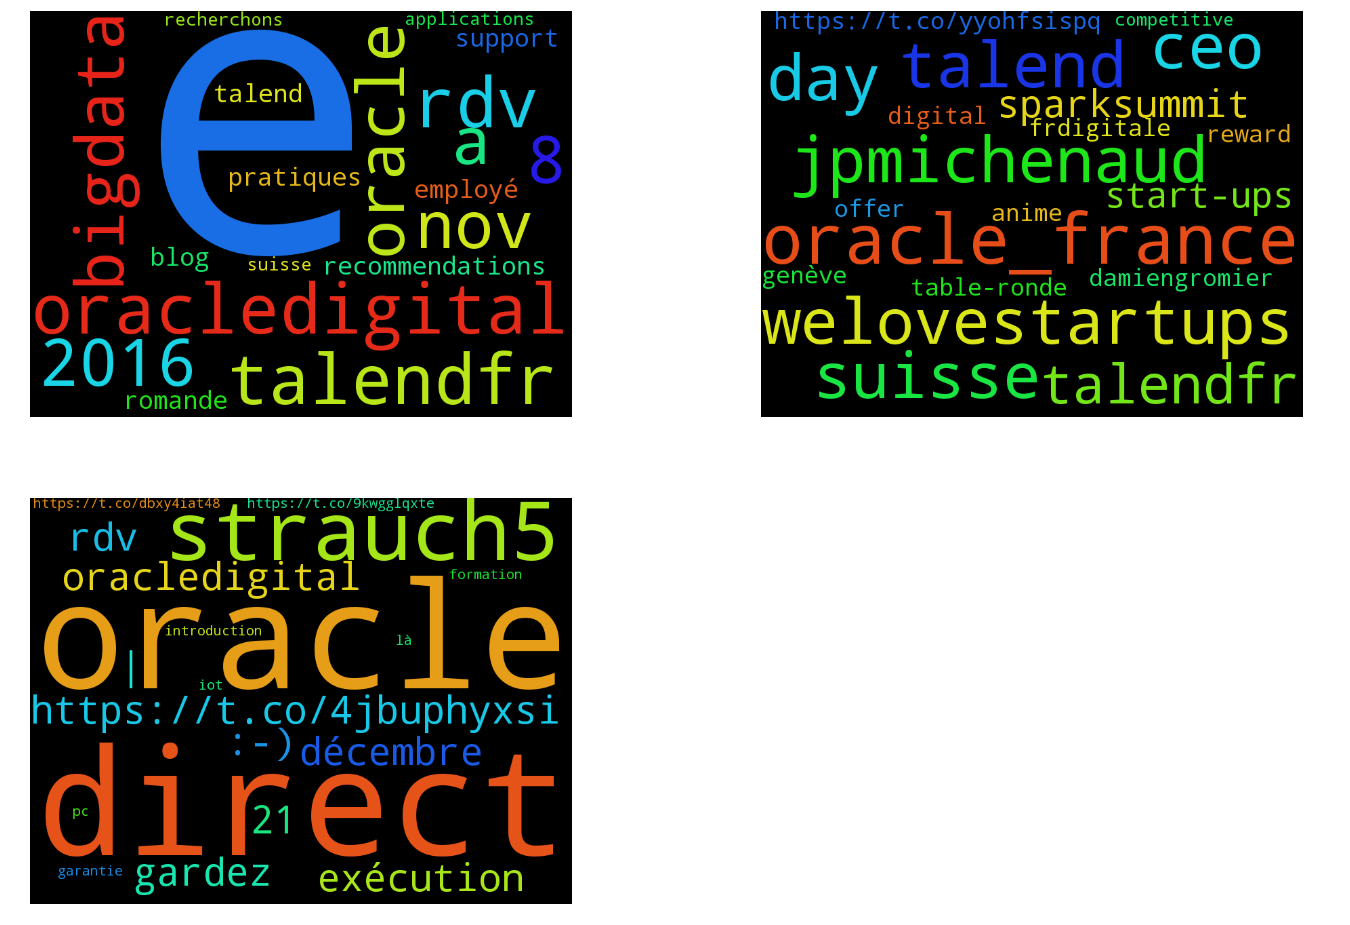

In [32]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters - French

Topic #0:
5.1: e
3.6: 2016
3.6: talendfr
3.6: a
3.5: bigdata
2.9: recommendations
2.8: pratiques
2.8: blog
2.8: oracle
2.8: support
2.8: romande
2.8: employé
2.8: applications
2.7: suisse
2.7: recherchons
2.7: développons
2.7: implantation
2.0: talendconnect
2.0: periscope
2.0: ddos

Topic #1:
4.4: day
4.4: welovestartups
4.4: talend
4.4: nov
4.4: oracle_france
4.4: rdv
4.4: 8
4.4: jpmichenaud
4.4: talendfr
4.4: oracledigital
4.3: sparksummit
3.6: oracle
3.6: ceo
3.5: bigdata
2.8: digital
2.8: offer
2.8: entreprise
2.8: reward
2.8: genève
2.8: competitive

Topic #2:
3.6: oracle_france
2.8: day
2.8: oracle
2.8: strauch5
2.0: gardez
2.0: :-)
2.0: rdv
2.0: https://t.co/dbxy4iat48
2.0: direct
2.0: 21
2.0: e
2.0: là
2.0: exécution
2.0: voit
2.0: oracledigital
2.0: https://t.co/9kwgglqxte
2.0: décembre
2.0: welovestartups
2.0: nipconf
2.0: encore

Topic #3:
3.6: https://t.co/yyohfsispq
3.6: damiengromier
3.6: start-ups
3.6: frdigitale
3.6: anime
3.6: oracle_france
3.6: table-ronde
3.6: welov

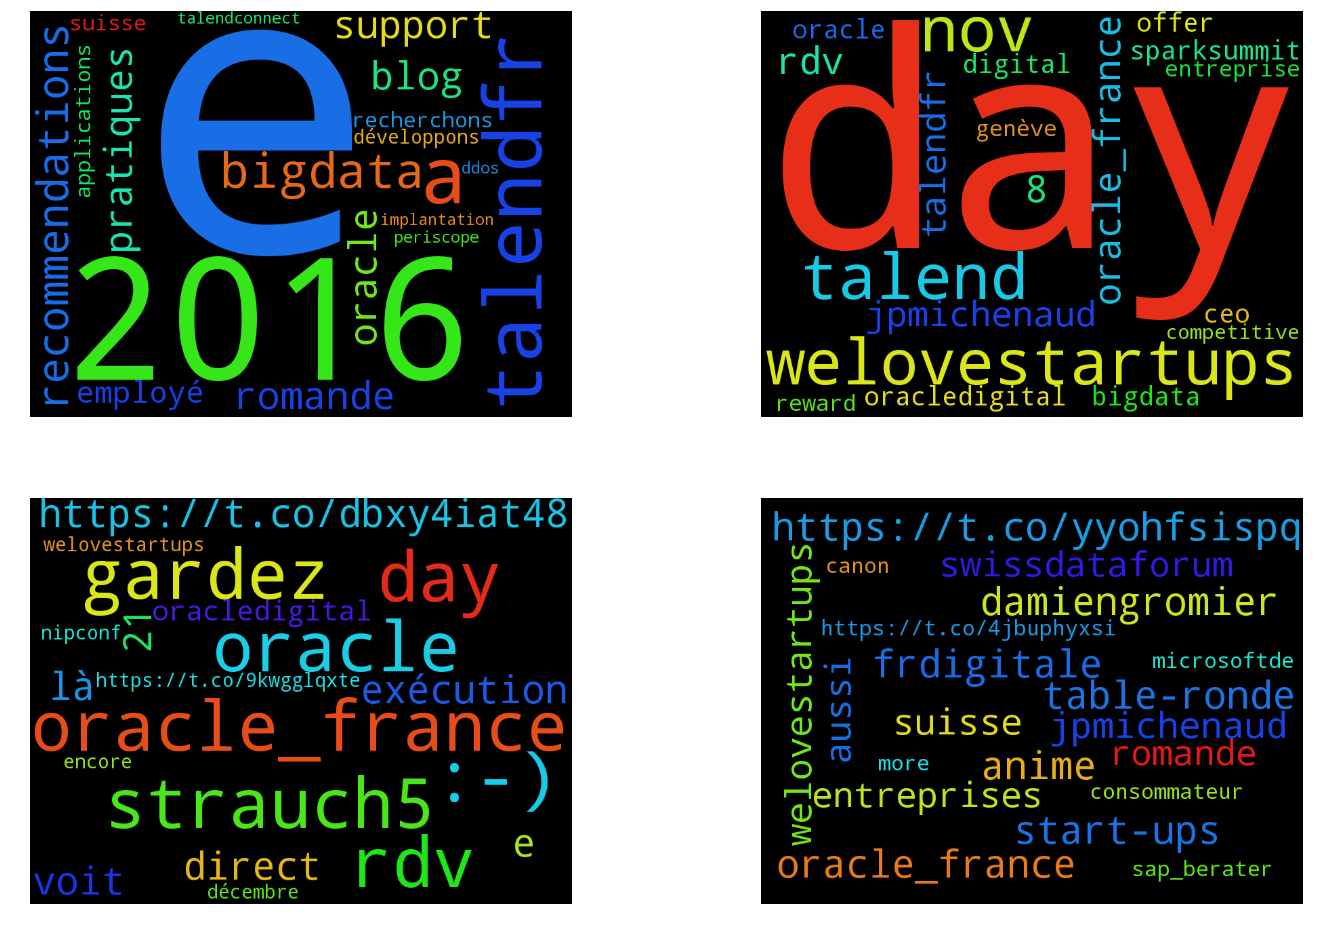

In [33]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

Co-occurrences for: oracle
blog               3
strauch5           3
recommendations    3
solutions          2
day                2
erp                2
garantie           2
rdv                2
oraclefinfr        2
jpmichenaud        2
oracledigital      2
exécution          2
Name: oracle, dtype: int64




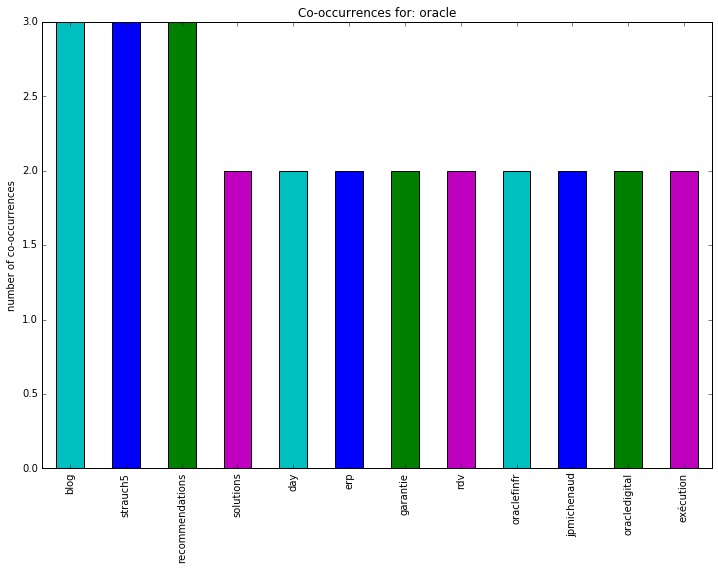

KeyError: 'the label [microsoft] is not in the [index]'

In [34]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_fr)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)

vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.columns = vocab
co_occurrences.head()

words = ['oracle', 'microsoft']    
n = 12
colors = 'cbgm'

for w in words: 
    coocs = get_co_occurrences(co_occurrences, w, n)
    print('Co-occurrences for: {}\n{}\n\n'.format(w, coocs))
    plot_co_occurrences(w, coocs)